# Usage example of nutpie

In [1]:
# We can control the number cores that are used by an environment variable:
%env RAYON_NUM_THREADS=12

env: RAYON_NUM_THREADS=12


In [2]:
import pytensor
import pytensor.tensor as pt
import pymc as pm
import numpy as np
import nutpie
import arviz
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## The dataset

We use the well known radon dataset in this notebook.

In [3]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(np.float64)
county_idx, counties = pd.factorize(data.county)
coords = {"county": counties, "obs_id": np.arange(len(county_idx))}

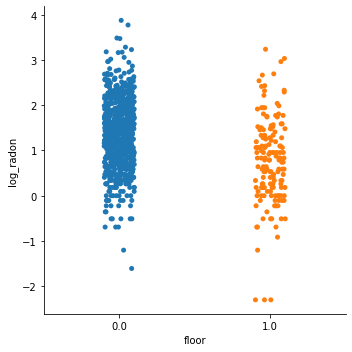

In [4]:
sns.catplot(
    data=data,
    x="floor",
    y="log_radon",
)

## Use as a sampler for pymc

In [20]:
with pm.Model(coords=coords, check_bounds=False) as pymc_model:
    intercept = pm.Normal("intercept", sigma=10)

    # County effects
    # TODO should be a CenteredNormal
    raw = pm.Normal("county_raw", dims="county")
    sd = pm.HalfNormal("county_sd")
    county_effect = pm.Deterministic("county_effect", raw * sd, dims="county")

    # Global floor effect
    floor_effect = pm.Normal("floor_effect", sigma=2)

    # County:floor interaction
    # Should also be a CenteredNormal
    raw = pm.Normal("county_floor_raw", dims="county")
    sd = pm.HalfNormal("county_floor_sd")
    county_floor_effect = pm.Deterministic(
        "county_floor_effect", raw * sd, dims="county"
    )

    mu = (
        intercept
        + county_effect[county_idx]
        + floor_effect * data.floor.values
        + county_floor_effect[county_idx] * data.floor.values
    )

    sigma = pm.HalfNormal("sigma", sigma=1.5)
    pm.Normal(
        "log_radon", mu=mu, sigma=sigma, observed=data.log_radon.values, dims="obs_id"
    )

In [6]:
%%time
# The compilation time is pretty bad right now, I think this can be improved a lot though
compiled_model = nutpie.compile_pymc_model(pymc_model)

CPU times: user 16.2 s, sys: 356 ms, total: 16.5 s
Wall time: 17.8 s


In [8]:
%%time
trace_pymc = nutpie.sample(compiled_model, chains=10)

CPU times: user 5.16 s, sys: 53.3 ms, total: 5.21 s
Wall time: 758 ms


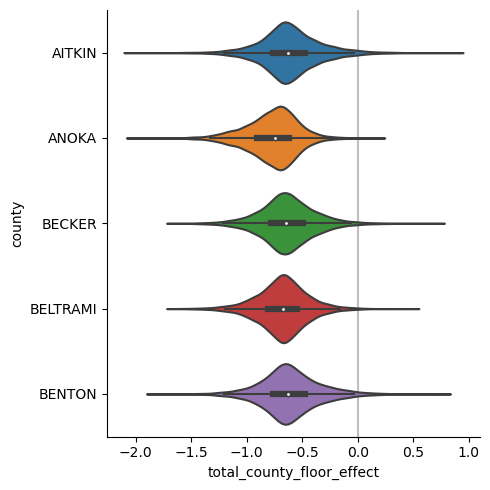

In [9]:
sns.catplot(
    data=(
        (trace_pymc.posterior.county_floor_effect + trace_pymc.posterior.floor_effect)
        .isel(county=slice(0, 5))
        .to_dataframe("total_county_floor_effect")
        .reset_index()
    ),
    x="total_county_floor_effect",
    y="county",
    kind="violin",
    orient="h",
)
plt.axvline(0, color="grey", alpha=0.5, zorder=-100)

## Use nutpie as a sampling backend for stan

In [10]:
%%file radon_model.stan
data {
    int<lower=0> n_counties;
    int<lower=0> n_observed; 
    array[n_observed] int<lower=1,upper=n_counties> county_idx;
    vector[n_observed] is_floor;
    vector[n_observed] log_radon;
} 
parameters {
    real intercept;
    
    vector[n_counties] county_raw;
    real<lower=0> county_sd;
    
    real floor_effect;
    
    vector[n_counties] county_floor_raw;
    real<lower=0> county_floor_sd;
    
    real<lower=0> sigma;
} 
transformed parameters {
    vector[n_counties] county_effect;
    vector[n_counties] county_floor_effect;
    vector[n_observed] mu;

    county_effect = county_sd * county_raw;
    county_floor_effect = county_floor_sd * county_floor_raw;

    mu = (
        intercept
        + county_effect[county_idx]
        + floor_effect * is_floor
        + county_floor_effect[county_idx] .* is_floor
    );
}
model {
    intercept ~ normal(0, 10);
    
    county_raw ~ normal(0, 1);
    county_sd ~ normal(0, 1);
    
    floor_effect ~ normal(0, 2);
    
    county_floor_raw ~ normal(0, 1);
    county_floor_sd ~ normal(0, 1);
    
    sigma ~ normal(0, 1.5);
    
    log_radon ~ normal(mu, sigma);
}

Overwriting radon_model.stan


In [11]:
data_stan = {
    "n_counties": len(counties),
    "n_observed": len(data),
    "county_idx": county_idx + 1,
    "is_floor": data.floor.values,
    "log_radon": data.log_radon.values,
}

coords_stan = {
    "county": counties,
}

dims_stan = {
    "county_raw": ("county",),
    "county_floor_raw": ("county",),
    "county_effect": ("county",),
    "county_floor_effect": ("county",),
    "mu": ("observation",),
}

In [12]:
%%time
stan_model = nutpie.compile_stan_model(
    data_stan,
    filename="radon_model.stan",
    coords=coords_stan,
    dims=dims_stan,
    cache=False
)

CPU times: user 249 ms, sys: 39.9 ms, total: 289 ms
Wall time: 20.2 s


In [14]:
%%time
trace_stan = nutpie.sample(stan_model, chains=10)

CPU times: user 10.4 s, sys: 125 ms, total: 10.5 s
Wall time: 1.23 s


## Comparison with pystan

In [15]:
import stan
import nest_asyncio

nest_asyncio.apply()

In [16]:
%%time
with open("radon_model.stan", "r") as file:
    model = stan.build(file.read(), data=data_stan)

Building...



Building: found in cache, done.

CPU times: user 86.3 ms, sys: 3.24 ms, total: 89.6 ms
Wall time: 87.1 ms


In [36]:
%%time
trace_pystan = model.sample(num_chains=10, save_warmup=True)

Sampling:   0%
Sampling:  10% (2000/20000)
Sampling:  20% (4000/20000)
Sampling:  30% (6000/20000)
Sampling:  40% (8000/20000)
Sampling:  50% (10000/20000)
Sampling:  60% (12000/20000)
Sampling:  70% (14000/20000)
Sampling:  80% (16000/20000)
Sampling:  90% (18000/20000)
Sampling: 100% (20000/20000)
Sampling: 100% (20000/20000), done.
Messages received during sampling:
  Gradient evaluation took 0.000307 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000357 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.57 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_acld9lfg/model_c5hg34nq.stan', line 49, column 4 to column 34)
  If this warning occur

CPU times: user 31.2 s, sys: 3.6 s, total: 34.8 s
Wall time: 46.4 s


In [37]:
trace_pystan = arviz.from_pystan(trace_pystan, save_warmup=True)

/home/adr/git/arviz/arviz/data/io_pystan.py:986: UserWarning: save_warmup is not currently supported for PyStan3
  warnings.warn(


## Comparison to the pymc sampler

In [23]:
%%time
with pymc_model:
    trace_py = pm.sample(
        init="jitter+adapt_diag_grad",
        draws=1000,
        chains=10,
        cores=10,
        idata_kwargs={"log_likelihood": False},
        compute_convergence_checks=False,
        target_accept=0.8,
        discard_tuned_samples=False,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [intercept, county_raw, county_sd, floor_effect, county_floor_raw, county_floor_sd, sigma]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 13 seconds.


CPU times: user 14.2 s, sys: 938 ms, total: 15.2 s
Wall time: 26 s


## Early convergance speed

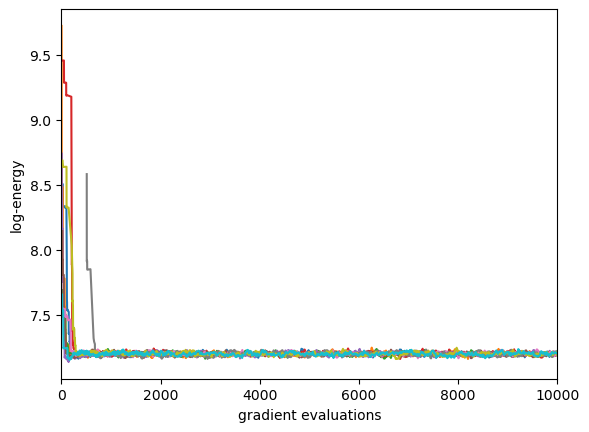

In [91]:
plt.plot((trace_pymc.warmup_sample_stats.n_steps).isel(draw=slice(0, 1000)).cumsum("draw").T, np.log(trace_pymc.warmup_sample_stats.energy.isel(draw=slice(0, 1000)).T));
plt.xlim(0, 10000)
plt.ylabel("log-energy")
plt.xlabel("gradient evaluations");

In [55]:
trace_cmdstan = arviz.from_cmdstan("output_*.csv", save_warmup=True)

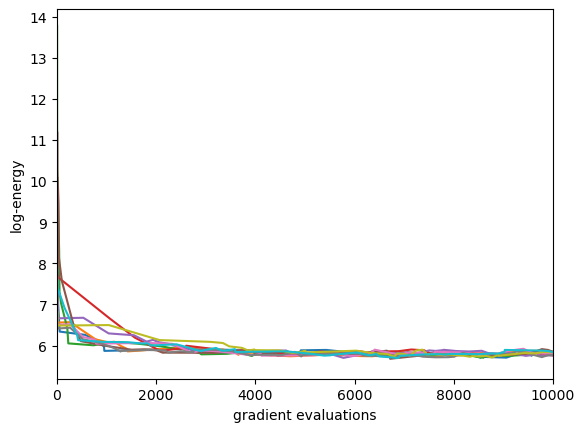

In [89]:
plt.plot((trace_cmdstan.warmup_sample_stats.n_steps).isel(draw=slice(0, 1000)).cumsum("draw").T, np.log(trace_cmdstan.warmup_sample_stats.energy.isel(draw=slice(0, 1000)).T));
plt.xlim(0, 10000)
plt.ylabel("log-energy")
plt.xlabel("gradient evaluations");

The new implementation only use about a third of gradient evaluations during tuning

In [92]:
trace_cmdstan.warmup_sample_stats.n_steps.sum()

<xarray.DataArray 'n_steps' ()>
array(387593)

In [93]:
trace_stan.warmup_sample_stats.n_steps.sum()

<xarray.DataArray 'n_steps' ()>
array(114200)

## Comparison to cmdstan

Run on the commandline:
```
env STAN_THREADS=1 cmdstan_model radon_model.stan
```

In [67]:
import json

In [ ]:
stan.common.simdjson

In [79]:
type({name: int(val) if isinstance(val, int) else list(val) for name, val in data_stan.items()}["county_idx"][0])

numpy.int64

In [80]:
data_json = {}
for name, val in data_stan.items():
    if isinstance(val, int):
        data_json[name] = int(val)
        continue
    
    if val.dtype == np.int64:
        data_json[name] = list(int(x) for x in val)
        continue
    
    data_json[name] = list(val)
    
with open("radon.json", "w") as file:
    json.dump(data_json, file)

In [83]:
%%time
out = !./radon_model sample num_chains=10 save_warmup=1 data file=radon.json num_threads=10

CPU times: user 17.8 ms, sys: 26.8 ms, total: 44.6 ms
Wall time: 4.34 s


In [84]:
trace_cmdstan = arviz.from_cmdstan("output_*.csv", save_warmup=True)

## Gradient evals per effective sample

nutpie uses fewer gradient evaluations per effective sample in this model.

In [85]:
trace_cmdstan.sample_stats.n_steps.sum() / arviz.ess(trace_cmdstan).min()

<xarray.Dataset>
Dimensions:              ()
Data variables:
    intercept            float64 51.27
    county_raw           float64 46.49
    county_sd            float64 69.52
    floor_effect         float64 26.28
    county_floor_raw     float64 37.7
    county_floor_sd      float64 143.7
    sigma                float64 30.67
    county_effect        float64 34.46
    county_floor_effect  float64 78.97
    mu                   float64 41.7

In [86]:
trace_stan.sample_stats.n_steps.sum() / arviz.ess(trace_stan).min()

<xarray.Dataset>
Dimensions:              ()
Data variables:
    intercept            float64 25.27
    county_raw           float64 30.51
    county_sd            float64 42.4
    floor_effect         float64 14.13
    county_floor_raw     float64 19.35
    county_floor_sd      float64 78.52
    sigma                float64 14.16
    county_effect        float64 18.25
    county_floor_effect  float64 41.69
    mu                   float64 25.71